In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Q1) Write a function that will shift an array by an arbitrary amount using a convolution. The function should take 2 arguments, an array and an amount by which to shift the array. Plot a gaussian that started in the centre of the array shifted by half the array length, in "gauss_shift.png".

Shifting an array {$x_n$} by an amount $m$ just amounts to taking the inverse Fourier transform ($F^{-1}$) of a convolution of $e^{-2\pi i k m/N}$ (Fourier transform of a delta), for $N$ the total number of points and $k\in[0,N-1]$, and the Fourier transform ($F$) of the original array ({$x_n$}), which we can write as {$X_k$}. This relation can written as, 

\begin{equation}
\{x_{n-m}\} = F^{-1}(\{X_k \cdot \text{exp}(-\frac{i 2 \pi k m}{N})\})_n
\end{equation}

and is implemented in the function `shift` below.

In [86]:
def shift(arr, m):
    arr_dft = np.fft.fft(arr)
    N = len(arr)
    k = np.arange(N) # integers from 0 to N-1
    shift_func = np.exp(-2j*k*np.pi*m/N)
    arr_shifted = np.fft.ifft(shift_func*arr_dft)
    r_arr_shifted = arr_shifted.real # take real part for plotting
    return r_arr_shifted

def gaussian(x, mu=0, sigma=1): # Gaussian with mean=0, sigma=1
    return np.exp(-(x-mu)**2 /(2*sigma**2))# / (sigma*(2*np.pi)**(1/2))

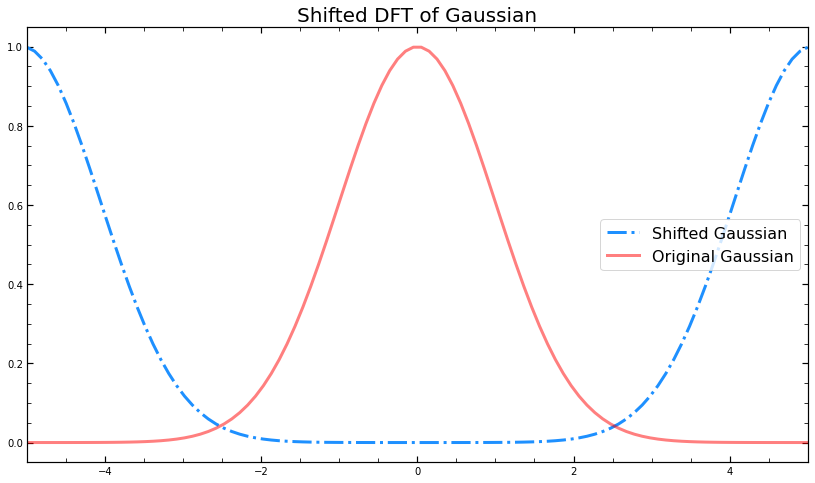

In [101]:
# Shift gaussian by half the array length

size_arr = 100
xx = np.linspace(-5, 5, size_arr)
gauss_arr = gaussian(xx)
shift_size = size_arr/2 # m
shifted_arr = shift(gauss_arr, shift_size)

fig, ax = plt.subplots(figsize=[14,8])
ax.plot(xx, shifted_arr, lw=3, linestyle='-.', color='dodgerblue', label='Shifted Gaussian')
ax.plot(xx, gauss_arr, lw=3, color='red', alpha=0.5, label='Original Gaussian')
ax.legend(fontsize=16)
ax.set_xlim(xmin=xx[0], xmax=xx[-1])
ax.set_title('Shifted DFT of Gaussian', fontsize=20);
#fig.savefig('gauss_shift.png');

# Q2) The correlation function $f\star g$ is $\int f(x)g(x+y) dx$. Through a proof similar to the one we saw for the convolution theorem, one can show $f\star g$=$F^{-1}(F(f)*conj(F(g)))$ (all discrete of course). Write a routine to take the correlation function of two arrays. Plot the correlation function of a Gaussian with itself.

We can obtain the correlation function following the inverse DFT of the DFT of $f$ multiplied by the complex conjugate of the DFT of $g$ (the conjugate DFT just amounts to taking the DFT of $g(-x)$, which for an array  simply implies taking the DFT of the flipped array, having assumed g(x) (equivalently the array) to be real). 

In [90]:
def corr2arr(arr1,arr2):
    ft_arr1 = np.fft.fft(arr1)
    conj_ft_arr2 = np.fft.fft(arr2[::-1]) # conjugate DFT is DFT of flipped array
    corr_arr12 = np.fft.ifft(ft_arr1*conj_ft_arr2)
    r_corr_arr12 = corr_arr12.real # take real part for plotting
    return r_corr_arr12/np.max(r_corr_arr12)

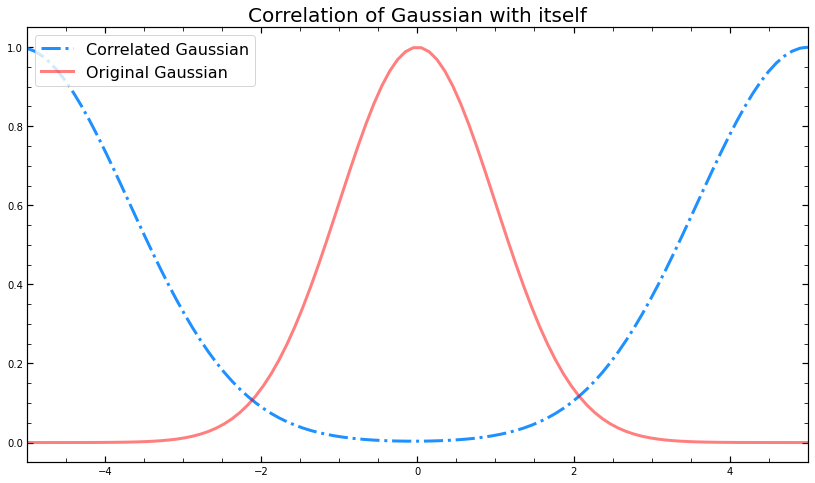

In [91]:
# Plot correlation function of a Gaussian with itself

size_arr2 = 100
xx2 = np.linspace(-5, 5, size_arr2)
gauss_arr2 = gaussian(xx2)
gauss_corr = corr2arr(gauss_arr2,gauss_arr2)

fig1, ax1 = plt.subplots(figsize=[14,8])
ax1.plot(xx2, gauss_corr, lw=3, linestyle='-.', color='dodgerblue', label='Correlated Gaussian')
ax1.plot(xx2, gauss_arr2, lw=3, color='red', alpha=0.5, label='Original Gaussian')
ax1.legend(fontsize=16)
ax1.set_xlim(xmin=xx2[0], xmax=xx2[-1])
ax1.set_title('Correlation of Gaussian with itself', fontsize=20);
#fig.savefig('correlation_Gaussian.png');

# Q3) Using the results from part 1 and part 2, write a routine to take the correlation function of a Gaussian (shifted by an arbitrary amount) with itself. How does the correlation depend on the shift? Does this surprise you?

In [94]:
def corr_shift_gauss(x, m):
    gauss_array = gaussian(x)
    shifted_gauss_array = shift(gauss_array, m)
    gauss_shift_corr = corr2arr(shifted_gauss_array, gauss_array)
    r_gauss_shift_corr = gauss_shift_corr.real
    return [gauss_array, shifted_gauss_array, r_gauss_shift_corr/np.max(r_gauss_shift_corr)] # 3 arrays to plot

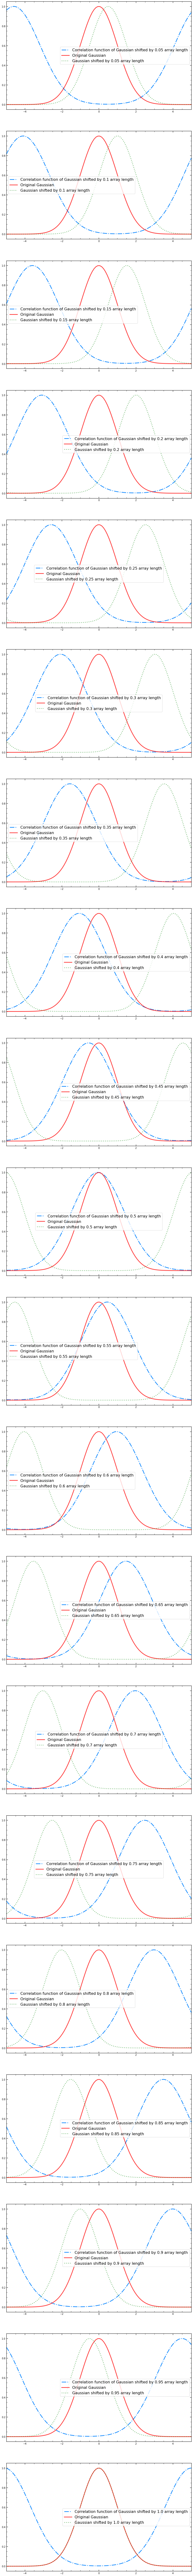

In [111]:
size_arr3 = 100
xx3 = np.linspace(-5, 5, size_arr3)
shifts = np.arange(5,101,5)
num_shifts=len(shifts)

fig2, ax2 = plt.subplots(num_shifts,figsize=[14,200])

for i in range(num_shifts): 
    reg_gauss, shifted_gauss, gauss_shift_corr = corr_shift_gauss(xx3,shifts[i])
    ax2[i].plot(xx3, gauss_shift_corr, lw=3, linestyle='-.', color='dodgerblue', label='Correlation function of Gaussian shifted by '+repr(shifts[i]/size_arr3)+' array length')
    ax2[i].plot(xx3, reg_gauss, lw=3, color='red', alpha=0.75, label='Original Gaussian')
    ax2[i].plot(xx3, shifted_gauss, lw=3, linestyle=':', color='green', alpha=0.5, label='Gaussian shifted by '+repr(shifts[i]/size_arr3)+ ' array length')
    ax2[i].legend(fontsize=16)
    ax2[i].set_xlim(xmin=xx2[0], xmax=xx2[-1])

#fig.savefig('shifted_corr_Gaussian.png');

The correlation function depends on the shift as........, This surprises me!

# Q4) The circulant (wrap-around) nature of the DFT can sometimes be problematic. Write a routine to take the convolution of two arrays without any danger of wrapping around. You may wish to add zeros to the end of the input arrays. Call your routine `conv_safe(f,g)`, where $f$ and $g$ are not necessarily the same length. How long is the output array?